In [9]:
# ============================================================
# CELL 1: Imports and Setup
# ============================================================
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits

# Set up paths
base_dir = os.path.expanduser("~/Desktop/Project2/Plots/WebSky_Maps")
tsz_file = os.path.join(base_dir, "tsz_2048.fits")
cib_file = os.path.join(base_dir, "cib_nu0225.fits")
out_dir  = os.path.join(base_dir, "output_tSZ_CIB_cross")
os.makedirs(out_dir, exist_ok=True)

%matplotlib inline
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 0,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "font.family": "DejaVu Sans",
    "text.usetex": False,           # <-- Keep False
    "mathtext.fontset": "dejavusans"  # or "cm", "stix"})
})


print("✓ Setup complete")
print(f"Output directory: {out_dir}")

✓ Setup complete
Output directory: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross


In [2]:
# ============================================================
# CELL 2: Load tSZ Map (Compton-y)
# ============================================================
print("\n" + "="*70)
print("LOADING tSZ MAP (Compton-y parameter)")
print("="*70)

with fits.open(tsz_file) as hdul:
    hdu = hdul[1]
    col_names = hdu.data.columns.names
    print(f"Available columns: {col_names}")
    
    # Use first column (should be 'PIXELS')
    col = col_names[0]
    y_map = hdu.data[col]
    
    # Flatten if multi-dimensional
    if y_map.ndim > 1:
        y_map = y_map.flatten()
    
    hdr = hdu.header
    nside_tsz = hdr['NSIDE']
    ordering_tsz = hdr['ORDERING'].upper()

print(f"\ntSZ Map Info:")
print(f"  Column: {col}")
print(f"  NSIDE: {nside_tsz}")
print(f"  NPIX: {len(y_map)}")
print(f"  ORDERING: {ordering_tsz}")
print(f"  y range: [{y_map.min():.3e}, {y_map.max():.3e}]")
print(f"  Mean y: {y_map.mean():.3e}")
print(f"  RMS y: {y_map.std():.3e}")


LOADING tSZ MAP (Compton-y parameter)
Available columns: ['PIXELS']

tSZ Map Info:
  Column: PIXELS
  NSIDE: 2048
  NPIX: 50331648
  ORDERING: RING
  y range: [4.692e-08, 2.167e-04]
  Mean y: 1.238e-06
  RMS y: 1.543e-06


In [3]:
# ============================================================
# CELL 3: Load CIB Map (MJy/sr)
# ============================================================
print("\n" + "="*70)
print("LOADING CIB MAP (MJy/sr at 225 GHz)")
print("="*70)

with fits.open(cib_file) as hdul:
    hdu = hdul[1]
    col_names = hdu.data.columns.names
    print(f"Available columns: {col_names}")
    
    # Use first column (should be 'T')
    col = col_names[0]
    I_map = hdu.data[col]
    
    # Flatten if multi-dimensional
    if I_map.ndim > 1:
        I_map = I_map.flatten()
    
    hdr = hdu.header
    nside_cib = hdr['NSIDE']
    ordering_cib = hdr['ORDERING'].upper()

print(f"\nCIB Map Info:")
print(f"  Column: {col}")
print(f"  NSIDE: {nside_cib}")
print(f"  NPIX: {len(I_map)}")
print(f"  ORDERING: {ordering_cib}")
print(f"  I range: [{I_map.min():.3f}, {I_map.max():.3f}] MJy/sr")
print(f"  Mean I: {I_map.mean():.3f} MJy/sr")
print(f"  RMS I: {I_map.std():.3f} MJy/sr")


LOADING CIB MAP (MJy/sr at 225 GHz)
Available columns: ['T']

CIB Map Info:
  Column: T
  NSIDE: 4096
  NPIX: 201326592
  ORDERING: RING
  I range: [0.000, 77.725] MJy/sr
  Mean I: 0.035 MJy/sr
  RMS I: 0.024 MJy/sr


In [4]:
#============================================================
# CELL 4: Match Resolutions (Downsample to Common NSIDE)
# ============================================================
print("\n" + "="*70)
print("MATCHING RESOLUTIONS")
print("="*70)

# Use the lower resolution (tSZ is NSIDE=2048)
nside_common = min(nside_tsz, nside_cib)
print(f"Common NSIDE: {nside_common}")

# Downsample CIB if needed
if nside_cib > nside_common:
    print(f"Downgrading CIB from NSIDE={nside_cib} to {nside_common}...")
    I_map_matched = hp.ud_grade(I_map, nside_out=nside_common, 
                                order_in='RING', order_out='RING')
else:
    I_map_matched = I_map

# Ensure tSZ is at common resolution
if nside_tsz > nside_common:
    print(f"Downgrading tSZ from NSIDE={nside_tsz} to {nside_common}...")
    y_map_matched = hp.ud_grade(y_map, nside_out=nside_common,
                                order_in='RING', order_out='RING')
else:
    y_map_matched = y_map

print(f"\n✓ Both maps now at NSIDE={nside_common}, NPIX={len(y_map_matched)}")
print(f"  tSZ: y ∈ [{y_map_matched.min():.3e}, {y_map_matched.max():.3e}]")
print(f"  CIB: I ∈ [{I_map_matched.min():.3f}, {I_map_matched.max():.3f}] MJy/sr")


MATCHING RESOLUTIONS
Common NSIDE: 2048
Downgrading CIB from NSIDE=4096 to 2048...

✓ Both maps now at NSIDE=2048, NPIX=50331648
  tSZ: y ∈ [4.692e-08, 2.167e-04]
  CIB: I ∈ [0.001, 19.460] MJy/sr


In [5]:
# ============================================================
# CELL 5: Ensure RING Ordering
# ============================================================
print("\n" + "="*70)
print("ENSURING RING ORDERING")
print("="*70)

# Convert to RING if needed
if ordering_tsz == 'NESTED':
    print("Converting tSZ from NESTED to RING...")
    y_ring = hp.reorder(y_map_matched, n2r=True)
else:
    y_ring = y_map_matched

if ordering_cib == 'NESTED':
    print("Converting CIB from NESTED to RING...")
    I_ring = hp.reorder(I_map_matched, n2r=True)
else:
    I_ring = I_map_matched

print("✓ Both maps in RING ordering")


ENSURING RING ORDERING
✓ Both maps in RING ordering


In [6]:
# %%
# ==============================================================
# 6. Compute Power Spectra (with caching)
# ==============================================================

import pickle
from pathlib import Path

print("\n" + "="*70)
print("COMPUTING POWER SPECTRA")
print("="*70)

# Cache setup
cache_dir = Path(out_dir) / "cache"
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / "tsz_cib_cross_powerspectra.pkl"

force_recompute = False  # Toggle to force recompute

lmax = min(3 * nside_common - 1, 5000)
print(f"lmax = {lmax}")

if force_recompute or not cache_file.exists():
    print("  → Computing power spectra (this may take a few minutes)...")
    import time
    start = time.time()
    
    cl_yy = hp.anafast(y_ring, lmax=lmax)
    cl_II = hp.anafast(I_ring, lmax=lmax)
    cl_cross = hp.anafast(y_ring, I_ring, lmax=lmax)
    
    elapsed = time.time() - start
    print(f"  → Done in {elapsed:.1f}s → saving cache...")
    
    with open(cache_file, 'wb') as f:
        pickle.dump((cl_yy, cl_II, cl_cross), f)
    print(f"  → Cached: {cache_file}")
else:
    print(f"  → Loading cached power spectra from {cache_file}")
    with open(cache_file, 'rb') as f:
        cl_yy, cl_II, cl_cross = pickle.load(f)

# Convert to D_ℓ
ell = np.arange(len(cl_cross))
Dl_yy = ell * (ell + 1) * cl_yy / (2 * np.pi)
Dl_II = ell * (ell + 1) * cl_II / (2 * np.pi)
Dl_cross = ell * (ell + 1) * cl_cross / (2 * np.pi)

# Diagnostics
l_check = 3000
print(f"\nAt ℓ = {l_check}:")
print(f" D_ℓ^{{tSZ auto}} = {Dl_yy[l_check]:.3e} y²")
print(f" D_ℓ^{{CIB auto}} = {Dl_II[l_check]:.3e} (MJy/sr)²")
print(f" D_ℓ^{{cross}} = {Dl_cross[l_check]:.3e} y·MJy/sr")


COMPUTING POWER SPECTRA
lmax = 5000
  → Computing power spectra (this may take a few minutes)...
  → Done in 49.3s → saving cache...
  → Cached: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cache/tsz_cib_cross_powerspectra.pkl

At ℓ = 3000:
 D_ℓ^{tSZ auto} = 9.512e-13 y²
 D_ℓ^{CIB auto} = 6.625e-05 (MJy/sr)²
 D_ℓ^{cross} = 2.224e-09 y·MJy/sr


In [7]:
# ============================================================
# CELL 7: Save Power Spectrum Data
# ============================================================
print("\n" + "="*70)
print("SAVING POWER SPECTRUM DATA")
print("="*70)

# Save all three spectra
data_file = os.path.join(out_dir, "tsz_cib_cross_spectra.txt")
header = "ell  Cl_tSZ  Cl_CIB  Cl_cross  Dl_tSZ  Dl_CIB  Dl_cross"

np.savetxt(data_file, 
           np.column_stack([ell, cl_yy, cl_II, cl_cross, 
                           Dl_yy, Dl_II, Dl_cross]),
           header=header,
           fmt='%.6e')

print(f"✓ Saved: {data_file}")
print(f"  File size: {os.path.getsize(data_file)/1024:.1f} KB")




SAVING POWER SPECTRUM DATA
✓ Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/tsz_cib_cross_spectra.txt
  File size: 444.5 KB



PLOTTING POWER SPECTRA (NATIVE UNITS)
✓ Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cross_power_native.pdf


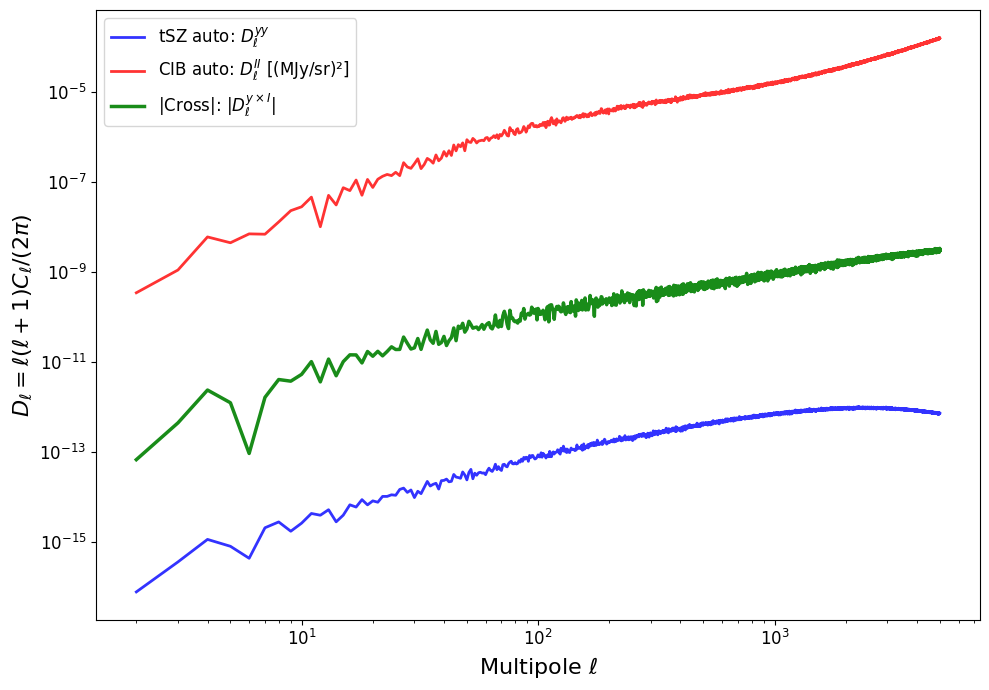

In [10]:
# ============================================================
# CELL 8: Plot Power Spectra (Native Units)
# ============================================================
print("\n" + "="*70)
print("PLOTTING POWER SPECTRA (NATIVE UNITS)")
print("="*70)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot auto-spectra and cross-spectrum
ax.loglog(ell[2:], Dl_yy[2:], 'b-', linewidth=2, 
         label=r'tSZ auto: $D_\ell^{yy}$', alpha=0.8)
ax.loglog(ell[2:], Dl_II[2:], 'r-', linewidth=2, 
         label=r'CIB auto: $D_\ell^{II}$ [(MJy/sr)²]', alpha=0.8)
ax.loglog(ell[2:], np.abs(Dl_cross[2:]), 'g-', linewidth=2.5, 
         label=r'|Cross|: $|D_\ell^{y \times I}|$', alpha=0.9)

# Formatting
#ax.set_xlim(10, lmax)
#ax.set_ylim(1e-16, 1e-3)
ax.set_xlabel(r'Multipole $\ell$', fontsize=16)
ax.set_ylabel(r'$D_\ell = \ell(\ell+1)C_\ell/(2\pi)$', fontsize=16)
#ax.set_title('tSZ × CIB Cross-Power Spectrum (Native Units)', fontsize=15)
ax.legend(fontsize=12, loc='best')
#ax.grid(True, which='both', alpha=0.3)
ax.tick_params(labelsize=12)

plt.tight_layout()
plot_file = os.path.join(out_dir, "cross_power_native.pdf")
plt.savefig(plot_file, dpi=200, bbox_inches='tight')
print(f"✓ Saved: {plot_file}")
plt.show()



CORRELATION ANALYSIS
✓ Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/correlation_coefficient.pdf


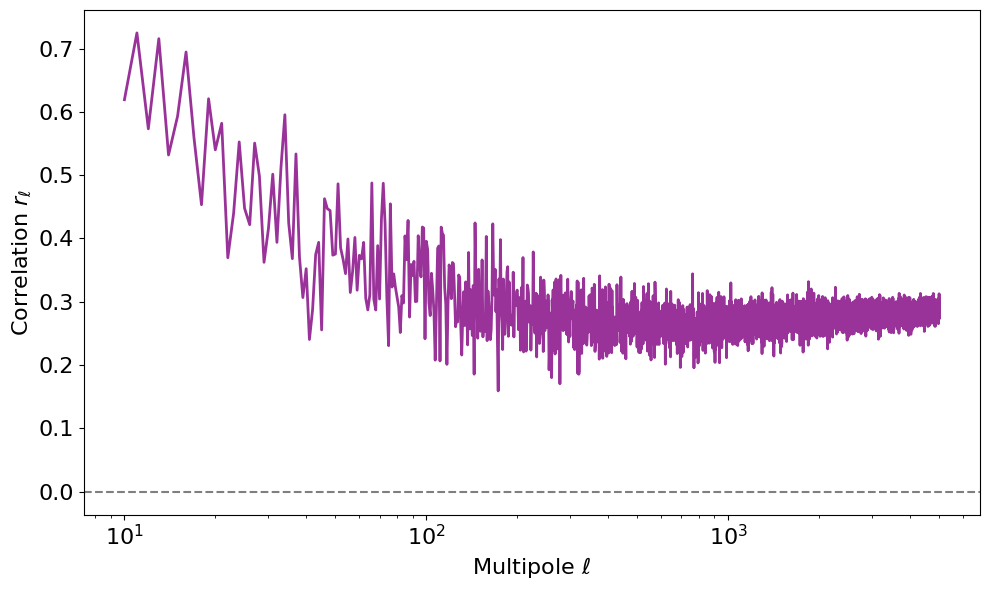


Correlation statistics (100 ≤ ℓ ≤ 3000):
  Mean r_ℓ: 0.274
  Min r_ℓ:  0.159
  Max r_ℓ:  0.424


In [12]:
# ============================================================
# CELL 9: Compute Correlation Coefficient
# ============================================================
print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)

# Correlation coefficient: r_ℓ = C_ℓ^{cross} / sqrt(C_ℓ^{yy} × C_ℓ^{II})
r_ell = np.zeros_like(cl_cross)
valid = (cl_yy > 0) & (cl_II > 0)
r_ell[valid] = cl_cross[valid] / np.sqrt(cl_yy[valid] * cl_II[valid])

# Plot correlation coefficient
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(ell[10:], r_ell[10:], 'purple', linewidth=2, alpha=0.8)
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
#ax.set_xlim(10, lmax)
#ax.set_ylim(-1, 1)
ax.set_xlabel(r'Multipole $\ell$', fontsize=16)
ax.set_ylabel(r'Correlation $r_\ell$', fontsize=16)
#ax.set_title('tSZ-CIB Correlation Coefficient', fontsize=15)
#ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=16)

plt.tight_layout()
corr_file = os.path.join(out_dir, "correlation_coefficient.pdf")
plt.savefig(corr_file, dpi=200, bbox_inches='tight')
print(f"✓ Saved: {corr_file}")
plt.show()

# Print some statistics
l_range = (ell >= 100) & (ell <= 3000)
print(f"\nCorrelation statistics (100 ≤ ℓ ≤ 3000):")
print(f"  Mean r_ℓ: {r_ell[l_range].mean():.3f}")
print(f"  Min r_ℓ:  {r_ell[l_range].min():.3f}")
print(f"  Max r_ℓ:  {r_ell[l_range].max():.3f}")



OPTIONAL: TEMPERATURE UNITS CONVERSION (225 GHz)
g(225 GHz) = 0.113
tSZ scale factor (y² → µK²): 9.417e+10
CIB scale factor (example): 1.000e+04
✓ Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cross_power_temperature.pdf


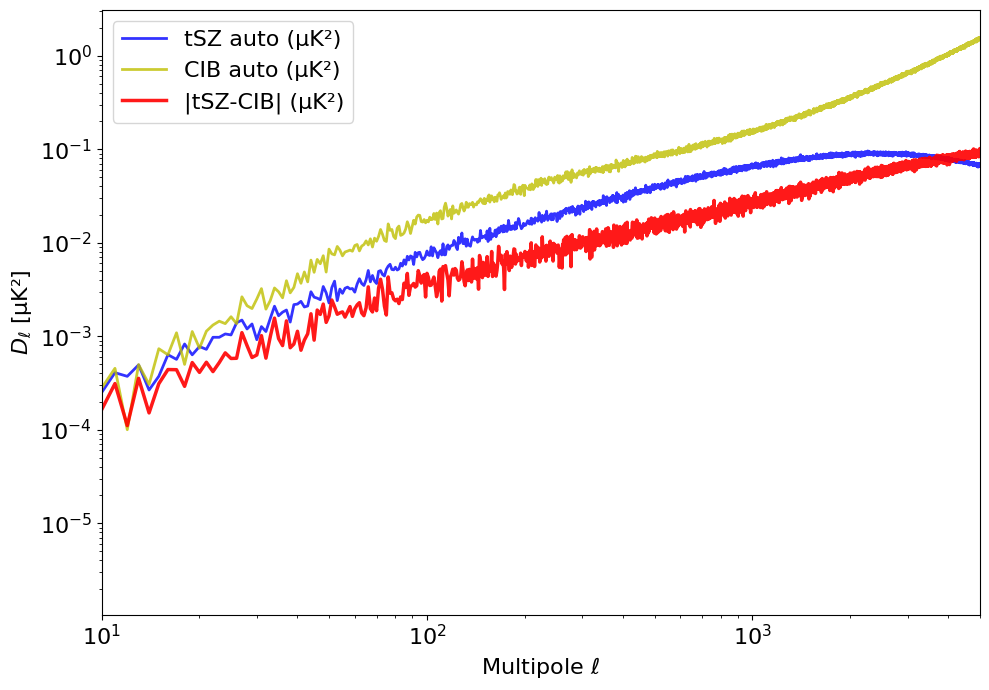


ANALYSIS COMPLETE!
All outputs saved to: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross


In [15]:
# ============================================================
# CELL 10: Optional - Convert to Temperature Units (µK²)
# ============================================================
print("\n" + "="*70)
print("OPTIONAL: TEMPERATURE UNITS CONVERSION (225 GHz)")
print("="*70)

# Conversion factors at 225 GHz
# These are approximate and depend on the exact frequency response
T_CMB = 2.726  # K

# tSZ: convert y to ΔT/T using g(ν) at 225 GHz
def g_nu(freq_GHz):
    """tSZ spectrum function"""
    x = freq_GHz / 56.84
    return x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4

g_225 = g_nu(225)  # ≈ -2.4
print(f"g(225 GHz) = {g_225:.3f}")

# Convert y² to (µK)²
scale_tsz = (g_225 * T_CMB * 1e6)**2  # (µK)²
print(f"tSZ scale factor (y² → µK²): {scale_tsz:.3e}")

# CIB: This requires knowing the CIB → temperature conversion
# For 225 GHz, this depends on the units and calibration
# Using a typical value (this may need adjustment)
scale_cib = 1e4  # Example: (MJy/sr)² → µK² conversion
print(f"CIB scale factor (example): {scale_cib:.3e}")

# Apply scaling
Dl_tsz_uK2 = Dl_yy * scale_tsz
Dl_cib_uK2 = Dl_II * scale_cib
Dl_cross_uK2 = Dl_cross * np.sqrt(scale_tsz * scale_cib)

# Plot in temperature units
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(ell[2:], Dl_tsz_uK2[2:], 'b-', linewidth=2, 
         label='tSZ auto (µK²)', alpha=0.8)
ax.loglog(ell[2:], Dl_cib_uK2[2:], 'y-', linewidth=2, 
         label='CIB auto (µK²)', alpha=0.8)
ax.loglog(ell[2:], np.abs(Dl_cross_uK2[2:]), 'r-', linewidth=2.5, 
         label='|tSZ-CIB| (µK²)', alpha=0.9)

ax.set_xlim(10, lmax)
ax.set_xlabel(r'Multipole $\ell$', fontsize=16)
ax.set_ylabel(r'$D_\ell$ [µK²]', fontsize=16)
#ax.set_title('tSZ × CIB Cross-Power (Temperature Units @ 225 GHz)', fontsize=15)
ax.legend(fontsize=16)
#ax.grid(True, which='both', alpha=0.3)
ax.tick_params(labelsize=16)

plt.tight_layout()
temp_file = os.path.join(out_dir, "cross_power_temperature.pdf")
plt.savefig(temp_file, dpi=200, bbox_inches='tight')
print(f"✓ Saved: {temp_file}")
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print(f"All outputs saved to: {out_dir}")
print("="*70)
